# Manuscript Figures

This notebook provides all code and documentation necessary to reproduce the figures presented in the manuscript *Strategies to Accelerate US Coal Power Phaseout Using Contextual Retirement Vulnerabilities*.

In [1]:
# Todo: replace with pip install retire 
import sys 
import pandas as pd 
import numpy as np 
import networkx as nx 
import plotly.express as px
import plotly.graph_objects as go

import umap
from typing import Dict
from itertools import product
import hdbscan
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from plotly.subplots import make_subplots
sys.path.append("..")

from retire.figures import PlotKit
from retire.data import load_dataset, load_clean_dataset, load_projection, load_graph, load_generator_level_dataset
from examples.heatmap_config import heatmap_config
from examples.dotplot_config import dotplot_config

/Users/stuartwayland/Projects/public/CoalAPI/.venv/lib/python3.12/site-packages/numba/cpython/old_hashing.py:477: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [2]:
raw_df = load_dataset()           
clean_df = load_clean_dataset()  
projection_df = load_projection() 
G = load_graph()    

plotkit = PlotKit(raw_df=raw_df, G=G)

## Figure 1a: Age-Based Retirement Scenario versus Current State of US Coal Retirements

This figure is based on generator-level data, which—while not the primary unit of analysis in the manuscript—is essential for capturing the true granularity of coal retirement patterns.  To ensure full reproducibility, the generator-level dataset is provided in the package's resources, and the code below reproduces Figure 1a as shown in the paper.

Our main dataset aggregates variables to the plant level (due to ~80% of the 62 studied variables being available only at that scale), and because of this the `retire` package does not include analytic functionality for generator-level operations. 

In [2]:


df = load_generator_level_dataset() 
# Define matching keys for colors/patterns
viz_color_dict = {
    'No Planned Retirement, Retired at 50yrs Old (GW)': ['#731f22', "/"],
    'Partial Plant Retirement – Generator Not Planned (GW)': ['#ff0000', "+"],
    'Partial Plant Retirement – Generator Planned (GW)': ['#ADD9F4', ""],
    'Full Planned Retirement (GW)': ['#476C9B', "x"]
}

# Bar plot: Stacked by retirement type
fig = go.Figure()
for col in ['No Planned Retirement, Retired at 50yrs Old (GW)',
            'Partial Plant Retirement – Generator Not Planned (GW)',
            'Partial Plant Retirement – Generator Planned (GW)',
            'Full Planned Retirement (GW)']:
    fig.add_trace(go.Bar(
        x=df['Year'],
        y=df[col],
        name=col,
        marker_color=viz_color_dict[col][0]
    ))

# Line: Age-Based Retirement Trajectory
fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['Total Coal Capacity at Age Based Retirement Trajectory (GW)'],
    name='Total Coal Capacity at <i>Age-Based</i> Retirement Trajectory',
    yaxis='y2',
    marker_color='grey',
    line_width=3
))

# Line: Planned Retirement Trajectory
fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['Total Coal Capacity at Planned Retirement Trajectory (GW)'],
    name='Total Coal Capacity at <i>Planned</i> Retirement Trajectory',
    yaxis='y2',
    mode="lines",
    marker_color='lightgrey',
    line_width=3
))

# Add annotation: Planned Retirement by 2035
final_val = df[df['Year'] == 2035]['Total Coal Capacity at Planned Retirement Trajectory (GW)'].values[0]
fig.add_annotation(
    x=2036.25,
    y=final_val,
    text=f"<span style='font-size: 90%;'><i>Planned Retirement Trajectory:</i></span><br><b>{final_val:,.0f} GW of Coal Capacity Remains by 2035</b>",
    showarrow=False,
    font=dict(size=12, color="black"),
    yref='y2',
    xshift=-25.5,
    align='left',
    xanchor='left'
)

# Add annotation: Age-based retirement case by 2035
age_based_val = df[df['Year'] == 2035]['Total Coal Capacity at Age Based Retirement Trajectory (GW)'].values[0]
unplanned_total = df.loc[df['Year'] <= 2035, 'No Planned Retirement, Retired at 50yrs Old (GW)'].sum() + \
                  df.loc[df['Year'] <= 2035, 'Partial Plant Retirement – Generator Not Planned (GW)'].sum()
fig.add_annotation(
    x=2036.25,
    y=age_based_val + 20,
    text=f"<span style='font-size: 90%;'><i>If the {int(round(unplanned_total, 0))} GW of coal generation with <b>no</b> current retirement plans retires at 50 yrs,</i></span><br><b>{age_based_val:,.0f} GW of Coal Capacity Remains by 2035</b>",
    showarrow=False,
    font=dict(size=12, color="black"),
    yref='y2',
    xshift=-25.5,
    align='left',
    xanchor='left'
)

# Add vertical line at 2035
fig.add_vline(x=2035, line_width=3, opacity=1, line_dash="dash", line_color="lightgrey")

# Format axes and layout
fig.update_layout(
    bargap=0.1,
    template='simple_white',
    barmode='stack',
    title_x=0,
    yaxis=dict(title='Capacity Retired (GW)'),
    yaxis2=dict(
        overlaying='y',
        side='right',
        title='Total Capacity Remaining (GW)',
        range=[0, 200]
    ),
    xaxis=dict(range=(2023.5, 2064)),
    font_size=14,
    margin=dict(r=10, l=10, t=20, b=10),
    legend=dict(x=0, y=-0.2, orientation='h', traceorder='grouped'),
    height=450,
    width=1200
)

# Export/Show
fig.show(config={
    "toImageButtonOptions": {
        "format": "svg",
        "filename": "whatIf_retirement_timeline",
    }
})

## Figure 1 (b): Retirement Status Map of the US Coal Fleet (as of 2022)

In [3]:
temp_map = raw_df.copy()
temp_map["Retirement Date"] = pd.to_numeric(
    temp_map["Retirement Date"], errors="coerce"
)
temp_map["Renewables or Coal"] = temp_map["Renewables or Coal"].str.capitalize()

# Force float dtype to allow 0.5
temp_map["ret_STATUS"] = temp_map["ret_STATUS"].astype(float)
temp_map.loc[
    (temp_map["ret_STATUS"] == 1) & (temp_map["Retirement Date"].isna()), "ret_STATUS"
] = 0.5

# Map retirement status and colors
ret_dict = {
    0: "No Planned Retirement",
    0.5: "Coal Generators at Plants Planning Partial Retirement Retired at 50yrs Old - Generator Not Planned Retirement",
    1: "Partial Planned Retirement",
    2: "Full Planned Retirement",
}
viz_colors = {
    ret_dict[k]: v[0]
    for k, v in {
        0.5: ["#731f22", "/"],
        1: ["#ADD9F4", ""],
        2: ["#476C9B", "x"],
        0: ["#ff0000", "+"],
    }.items()
}
temp_map["ret_STATUS"] = temp_map["ret_STATUS"].map(ret_dict)

# Clean + compute values
temp_map["Retirement Date"] = temp_map["Retirement Date"].fillna(2001).astype(int)
temp_map["Retirement Date Log Scaled"] = (
    np.log1p(temp_map["Retirement Date"] - 2000) * 100
)
temp_map["Date of Last Unit or Planned Retirement"] = temp_map[
    "Date of Last Unit or Planned Retirement"
].fillna("n/a")

# Safely convert and round problematic columns first
percent_cols = [
    "Estimated percentage who somewhat/strongly oppose setting strict limits on existing coal-fire power plants",
    "Percent difference",
]
for col in percent_cols:
    temp_map[col] = pd.to_numeric(temp_map[col], errors="coerce")

# Fill only object columns with 'n/a'
obj_cols = temp_map.select_dtypes(include="object").columns
temp_map[obj_cols] = temp_map[obj_cols].fillna("n/a")

# Plot
fig = px.scatter_geo(
    temp_map,
    lat="LAT",
    lon="LON",
    size="Total Nameplate Capacity (MW)",
    size_max=13,
    color="ret_STATUS",
    color_discrete_map=viz_colors,
    category_orders={"ret_STATUS": list(ret_dict.values())},
    hover_name="Plant Name",
    custom_data=[
        "ret_STATUS",
        "Age",
        "Total Nameplate Capacity (MW)",
        "Number of Coal Generators",
        "Date of Last Unit or Planned Retirement",
        "Utility Name",
        "Estimated percentage who somewhat/strongly oppose setting strict limits on existing coal-fire power plants",
        "Renewables or Coal",
        "Percent difference",
    ],
)

fig.update_traces(
    hovertemplate=(
        "<b>%{hovertext}</b> – <i>%{customdata[0]}</i><br><br>"
        "Age: %{customdata[1]} yrs<br>"
        "Capacity: %{customdata[2]:,.1f} MW<br>"
        "Num. Coal Units: %{customdata[3]}<br>"
        "Retirement Date: %{customdata[4]}<br><br>"
        "Utility: %{customdata[5]}<br>"
        "%{customdata[7]} are cheaper by %{customdata[8]:.1f}%<br>"
        "Community Opposition to Stricter Emissions Rules: %{customdata[6]:.0f}%<br>"
        "<extra></extra>"
    ),
    marker=dict(line=dict(color="rgb(50, 50, 50)", width=0.5)),
)

fig.update_geos(
    scope="usa",
    landcolor="#fcfcfc",
    subunitcolor="#e1e1e1",
    countrywidth=0.5,
    subunitwidth=0.5,
)

fig.update_layout(
    font_size=14,
    legend_title="",
    legend=dict(orientation="h", y=-0.15, x=0.5, xanchor="center", yanchor="bottom"),
    margin=dict(r=10, l=10, t=30, b=10),
    autosize=True,
)

fig.show()

# Figure 2: Graph-based classification of the US coal fleet 

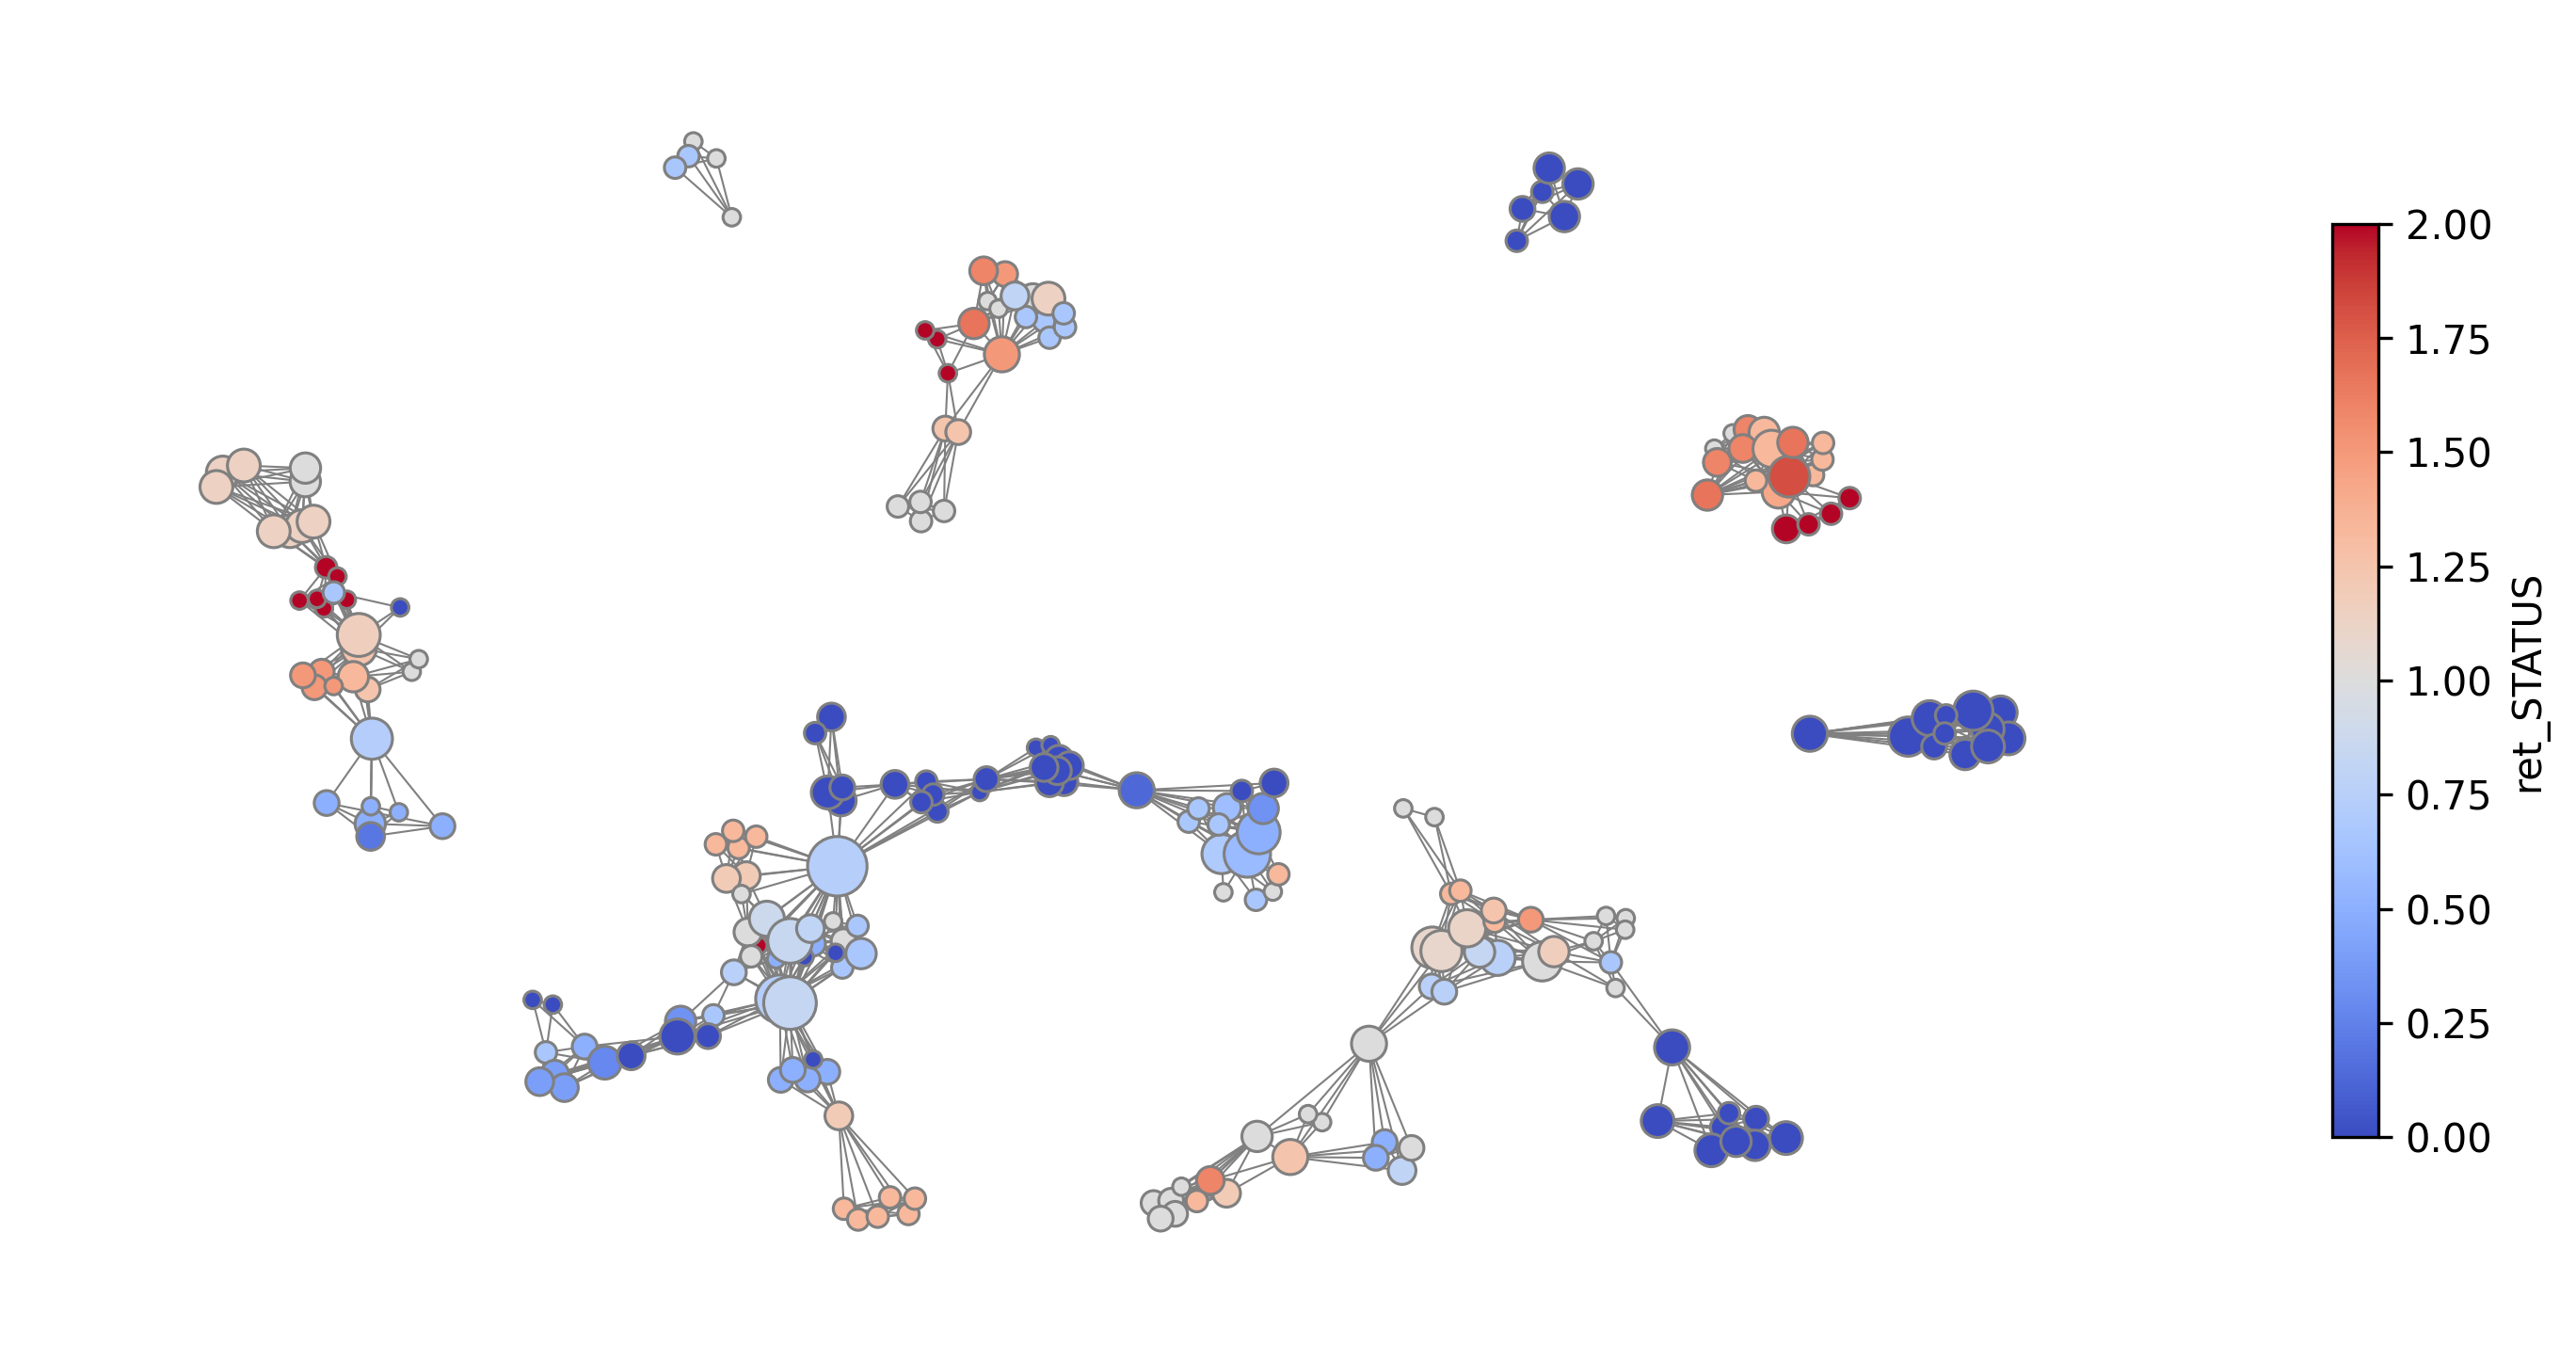

In [4]:
fig, ax = plotkit.drawGraph(show_colorbar=True,  col = "ret_STATUS", color_method="average")

# Figure 3: Key Group Characteristics

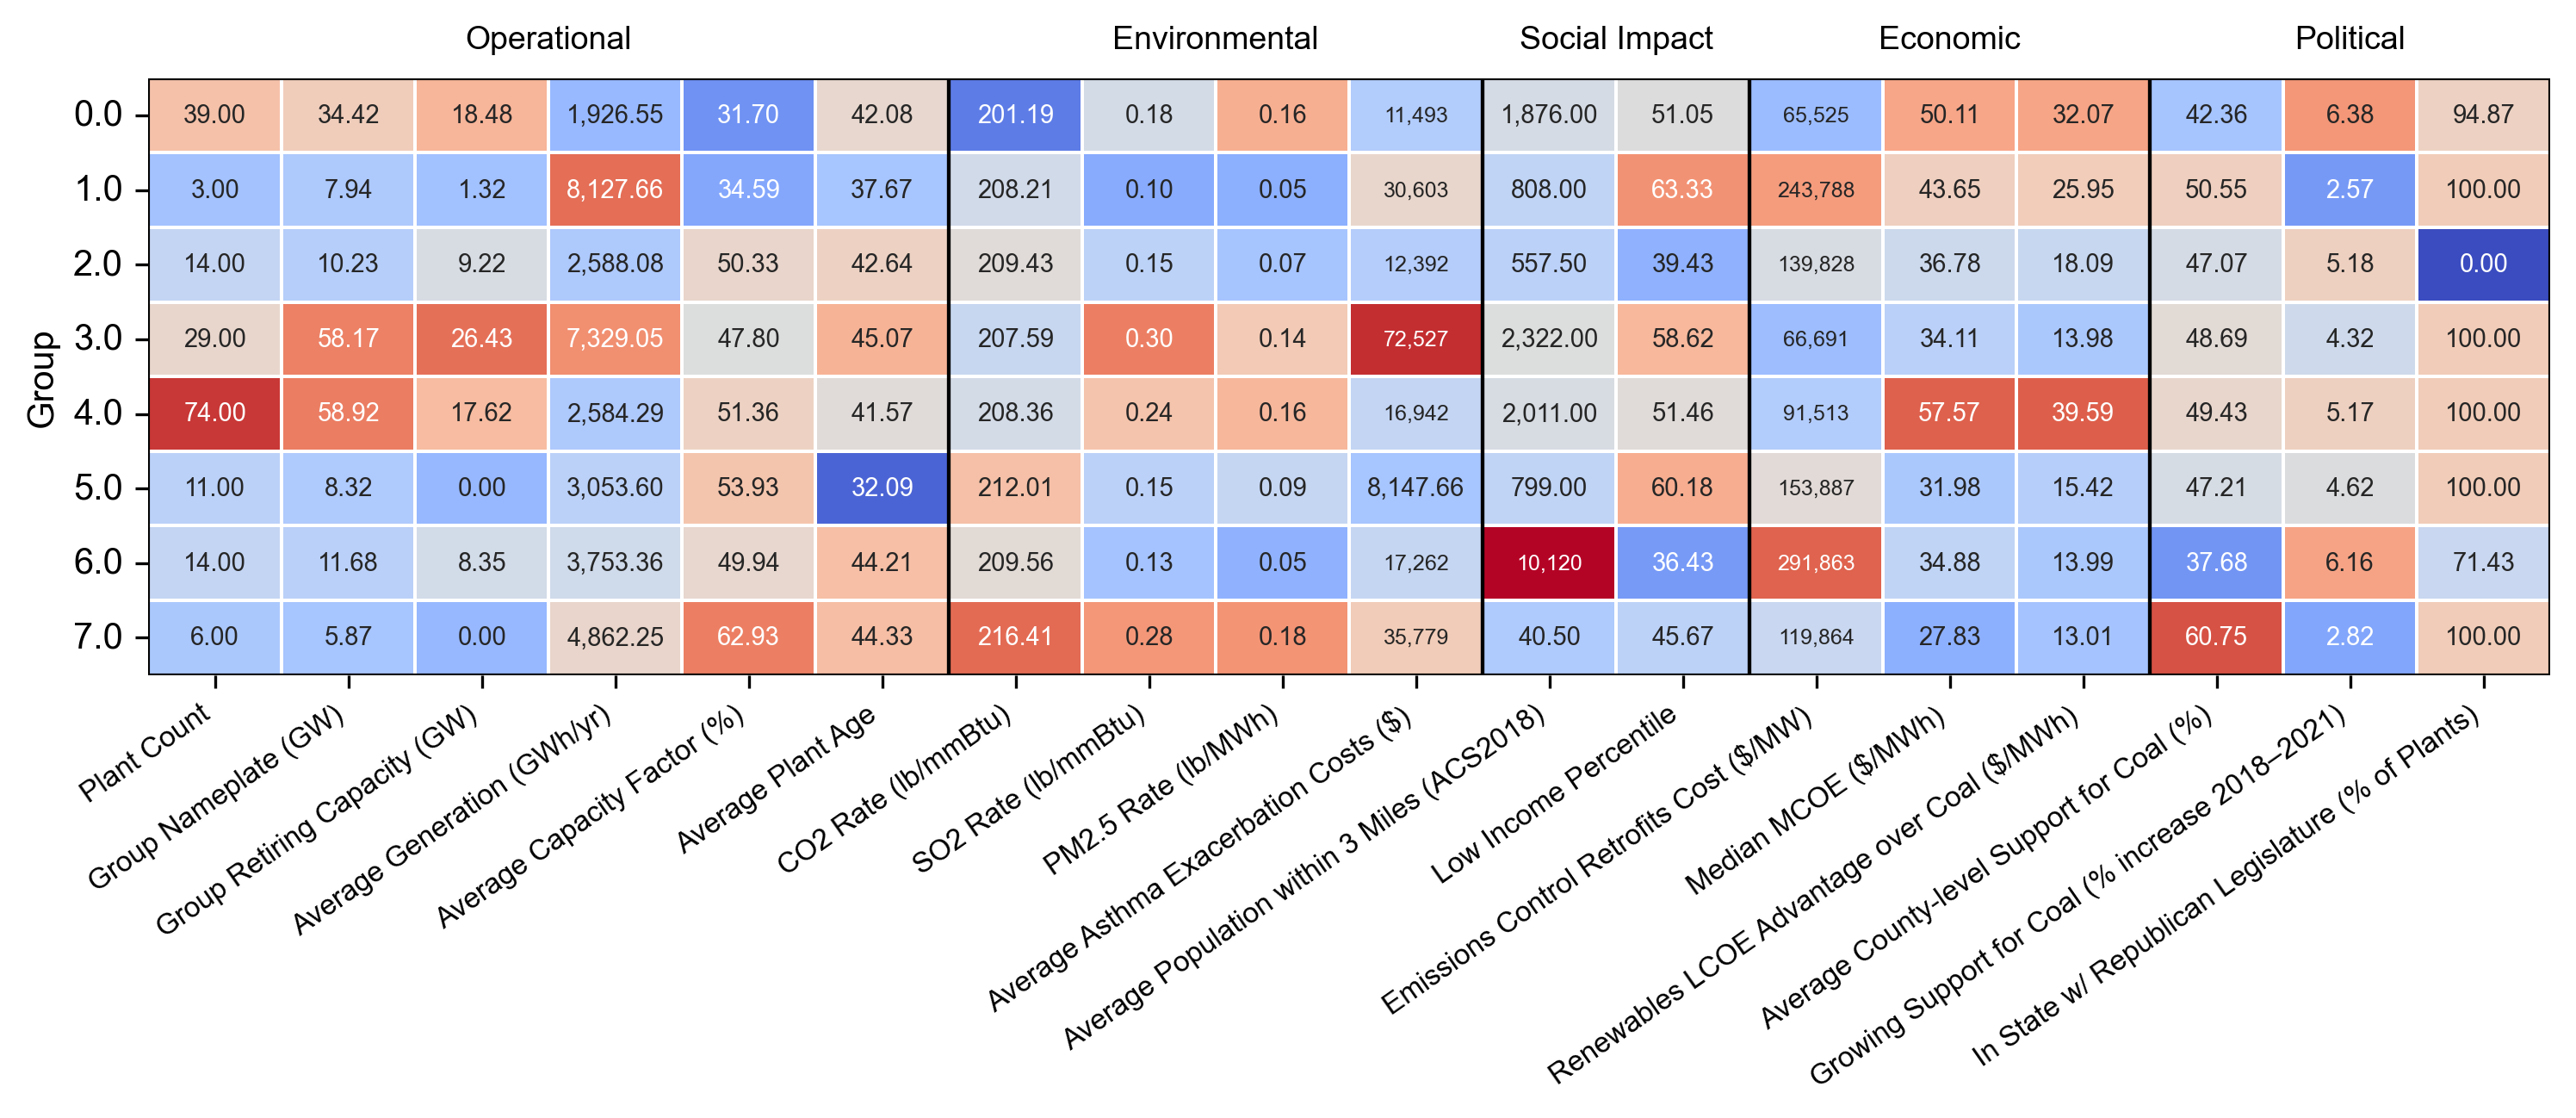

In [5]:
fig, ax = plotkit.drawHeatMap(config=heatmap_config)

## Figure 4: Group Vulnerability Map

In [6]:

def get_key_nodes(percent_retiring_dict, threshold=0.5):
    """
    Return nodes with retirement percent above a threshold.
    """
    return {node: val for node, val in percent_retiring_dict.items() if val > threshold}
def compute_retirement_by_node(G, df, col='Percent Capacity Retiring'):
    """
    For each node in the graph, calculate the average retirement percent
    from the associated plants (via membership indices).
    """
    percent_retiring = {}
    for node in G.nodes():
        indices = G.nodes[node].get("membership", [])
        if indices:
            percent_retiring[node] = df.loc[indices, col].mean()
        else:
            percent_retiring[node] = 0.0
    return percent_retiring
def process_group_sankey_df(
    G: nx.Graph,
    df: pd.DataFrame,
    group_num: int,
    threshold: float = 0.5,
    return_all: bool = False
) -> pd.DataFrame:
    """Builds Sankey-ready data for one group."""
    
    # Extract the subgraph for the group
    subgraph = list(nx.connected_components(G))[group_num]
    subG = G.subgraph(subgraph).copy()

    # Identify targets
    retiring_pct = compute_retirement_by_node(subG, df)
    targets = list(get_key_nodes(retiring_pct, threshold).keys())

    # Compute shortest distances to targets
    dist_data = {
        node: min(
            (nx.shortest_path_length(subG, source=node, target=t, weight='weight') for t in targets),
            default=float('inf')
        )
        for node in subG.nodes
    }

    # Collect node data
    dfs = []
    for node, dist in dist_data.items():
        node_df = df.loc[subG.nodes[node]['membership']].copy()
        node_df['Distance Score'] = dist
        dfs.append(node_df)

    out_df = (
        pd.concat(dfs)
        .sort_values('Distance Score')
        .drop_duplicates('ORISPL')
        .reset_index(drop=True)
    )

    # Bin and label
    bins = [-float('inf'), 0, 1/3, 2/3, float('inf')]
    labels = ['High Proximity', 'Mid-Proximity', 'Low-Proximity', 'Far from Retirement']
    out_df['Target'] = pd.cut(out_df['Distance Score'], bins=bins, labels=labels)
    out_df['Target'] = out_df['Target'].astype(str)
    out_df.loc[out_df['ret_STATUS'] == 2, 'Target'] = 'Retiring'

    # Final formatting
    order = ['Retiring'] + labels
    out_df['Target'] = pd.Categorical(out_df['Target'], categories=order, ordered=True)
    out_df['Source'] = group_num

    if return_all:
        return out_df

    # Sankey format
    return (
        out_df.groupby('Target', observed=False)['ORISPL']
        .count()
        .reset_index()
        .rename(columns={'ORISPL': 'Value'})
        .assign(Source=group_num)
    )
def build_group_sankey(
    G: nx.Graph,
    df: pd.DataFrame,
    group_range: range = range(8),
    return_all: bool = False
) -> pd.DataFrame:
    """Runs process_group_sankey_df across multiple groups and combines output."""
    return pd.concat(
        [
            process_group_sankey_df(G, df, group_num, return_all=return_all).assign(group=group_num)
            for group_num in group_range
        ],
        ignore_index=True
    )


# Prepare data
build2 = build_group_sankey(G, raw_df, return_all=True)
build2['ret_STATUS'] = build2['ret_STATUS'].map({
    0: 'No Planned Retirement',
    0.5: 'Coal Generators at Plants Planning Partial Retirement Retired at 50yrs Old - Generator Not Planned Retirement',
    1: 'Partial Planned Retirement',
    2: 'Full Planned Retirement'
})

# Color and label mappings
target_colors = {
    'Far from Retirement': 'rgb(178,24,43)',
    'Low-Proximity': 'rgb(244,165,130)',
    'Mid-Proximity': 'rgb(230, 230, 230)',
    'High Proximity': 'rgb(146,197,222)',
    'Retiring': 'rgb(33,102,172)',
}

group_labels = {
    0: "Fuel Blend Plants", 1: "Retrofitted but Vulnerable Plants",
    2: "Democratic Majority Plants", 3: "High Health Impact Plants",
    4: "Expensive Plants", 5: "Young Plants",
    6: "Plants in Anti-Coal Regions", 7: "Air Quality Offenders"
}

# Create figure
fig = px.scatter_geo(
    build2,
    lat='LAT', lon='LON',
    size='Total Nameplate Capacity (MW)', size_max=13,
    color='Target', color_discrete_map=target_colors,
    category_orders={'Target': list(target_colors.keys())},
    facet_col='group', facet_col_wrap=3,
    facet_col_spacing=0, facet_row_spacing=0,
    hover_name='Plant Name',
    custom_data=[
        "ret_STATUS", "Age", "Total Nameplate Capacity (MW)",
        "Number of Coal Generators", "Date of Last Unit or Planned Retirement",
        "Utility Name", "Estimated percentage who somewhat/strongly oppose setting strict limits on existing coal-fire power plants",
        "Renewables or Coal", "Percent difference"
    ]
)

# Hover formatting
fig.update_traces(
    hovertemplate=(
        "<b>%{hovertext}</b> – <i>%{customdata[0]}</i><br><br>"
        "Age: %{customdata[1]:.0f} yrs<br>"
        "Capacity: %{customdata[2]:,.1f} MW<br>"
        "Num. Coal Units: %{customdata[3]}<br>"
        "Utility: %{customdata[5]}<br>"
        "<extra></extra>"
    ),
    marker=dict(line=dict(color='rgb(50, 50, 50)', width=0.5))
)

# Geo + layout updates
fig.update_geos(
    scope='usa', landcolor="rgb(252,252,252)", subunitcolor="rgb(225,225,225)",
    countrywidth=0.5, subunitwidth=0.5
)

fig.for_each_annotation(lambda a: a.update(
    text=f"Group {gid}:<i> {group_labels[int(gid)]}</i>"
    ) if (gid := a.text.split('=')[1].strip()).isdigit() else None
)

fig.update_layout(
    height=600, width=1000, font_size=12,
    legend_title='Retirement Proximity',
    legend=dict(orientation='v', y=0.07, x=0.77, yanchor='bottom', xanchor='left'),
    margin=dict(r=10, l=10, t=30, b=10)
)

fig.show()

# Figure 5: Retirement proximity Graphs of Group 0 (Fuel Blend Plants) and Group 4 (Expensive Plants)

 

<div class="alert alert-block alert-warning"> 

<b>Warning:</b> `retire` has updated to using forceatlas2_layout in our maintained codebase, so the component orientation is slightly different than the Graphic in Fig. 5. 

<b>Warning:</b>  `retire` has updated its labeling of target nodes from 'S' ('sink') to 'T' (target). 
 </div>

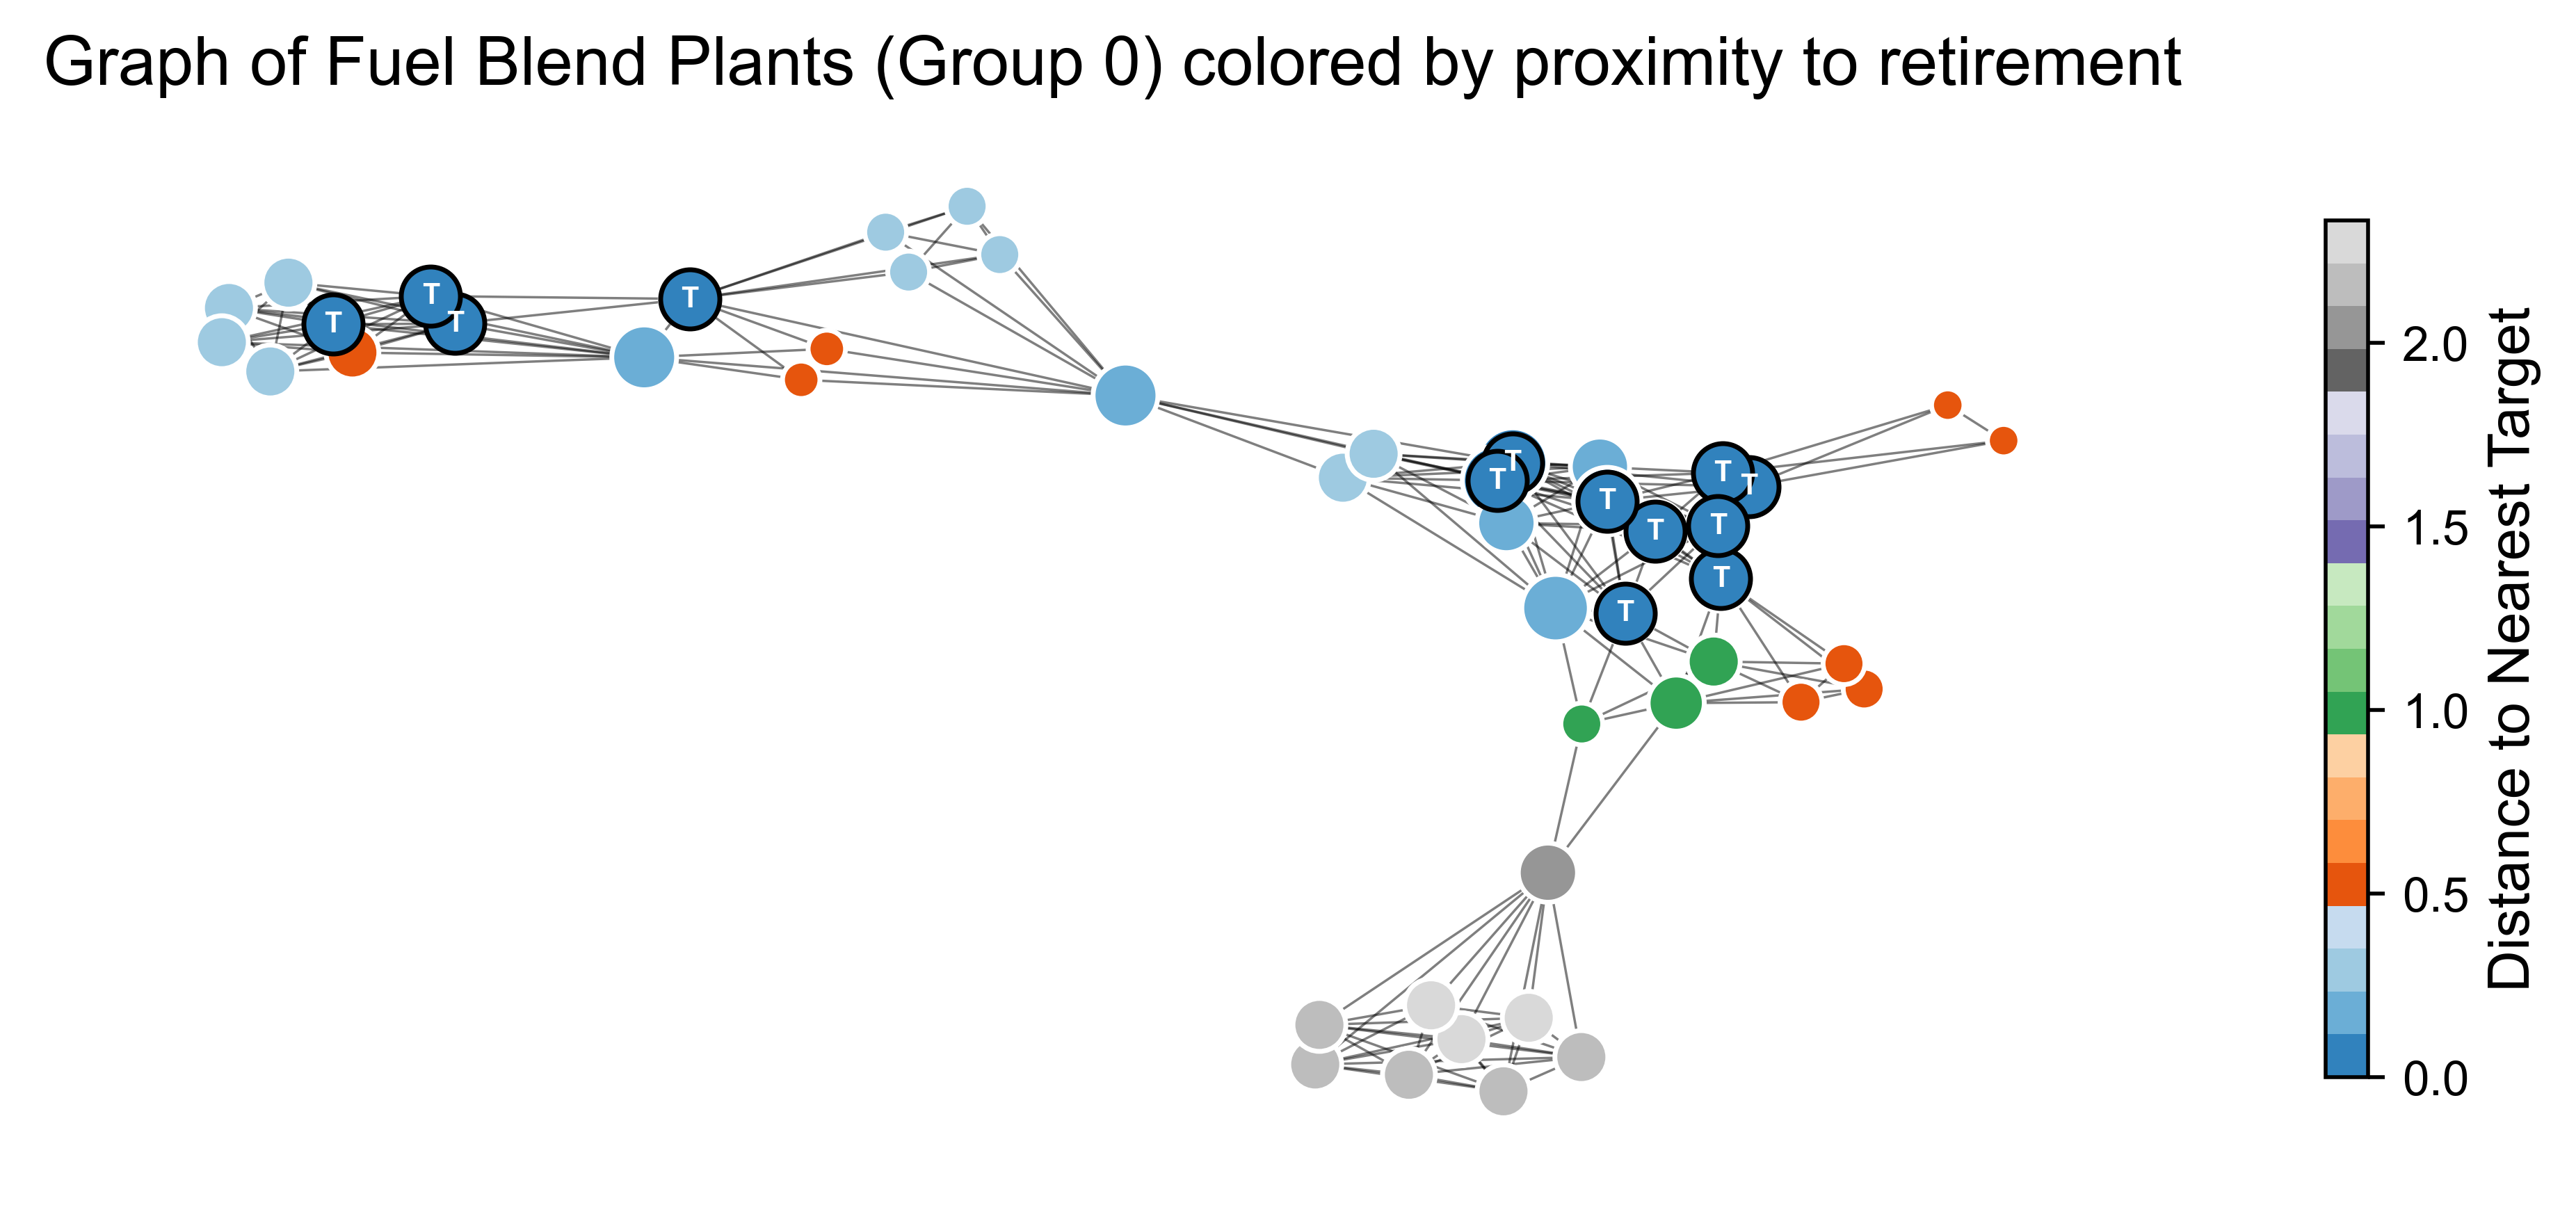

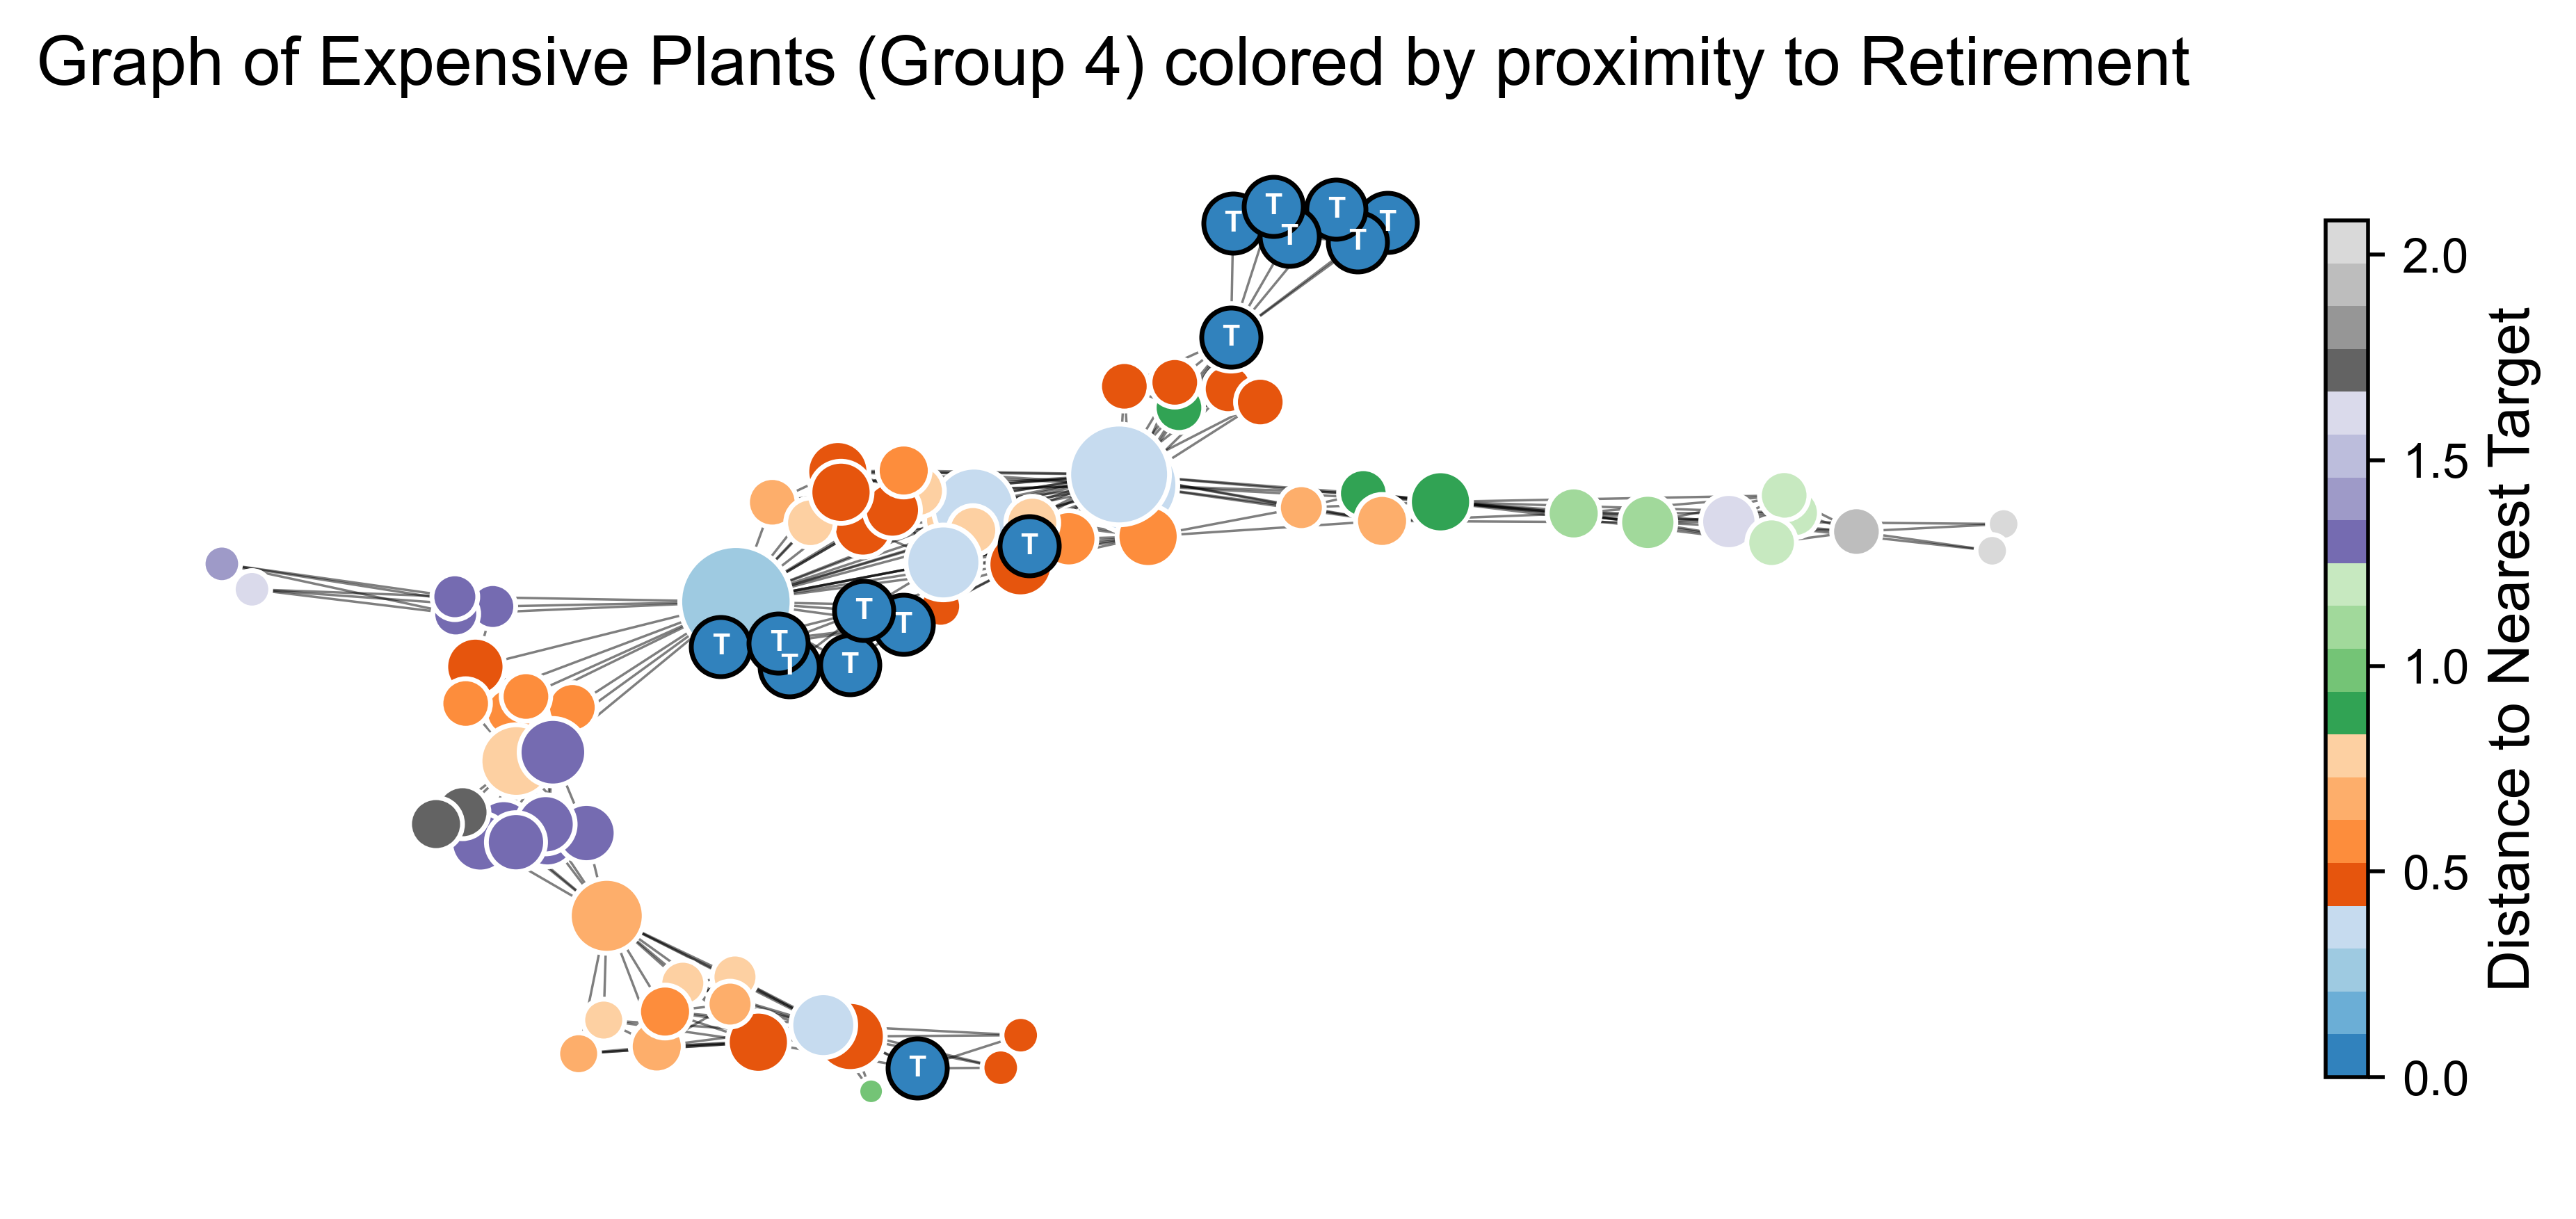

In [7]:
component = 0
threshold = 0.5 
col = "Percent Capacity Retiring"
retiring_nodes = plotkit.get_target_nodes(component=component,  col=col, threshold=threshold)
node_distances = plotkit.get_shortest_distances_to_targets(component=component, targets=retiring_nodes)
fig, ax = plotkit.drawPathDistance(component=component, 
                    targets=retiring_nodes, 
                    distances_dict=node_distances, 
                    title=f"Graph of Fuel Blend Plants (Group 0) colored by proximity to retirement",
                    seed=5, 
                    show_colorbar=True) 
component = 4
threshold = 0.5 
col = "Percent Capacity Retiring"
retiring_nodes = plotkit.get_target_nodes(component=component,  col=col, threshold=threshold)
node_distances = plotkit.get_shortest_distances_to_targets(component=component, targets=retiring_nodes)
fig, ax = plotkit.drawPathDistance(component=component, 
                    targets=retiring_nodes, 
                    distances_dict=node_distances, 
                    title=f"Graph of Expensive Plants (Group 4) colored by proximity to Retirement",
                    seed=5, 
                    show_colorbar=True) 

## Figure 6: Network Analysis of Group 3: High Health Impact Plants

<div class="alert alert-block alert-warning"> 

<b>Warning:</b> `retire` has updated to using forceatlas2_layout in our maintained codebase, so the component orientation is slightly different than the Graphic in Fig. 5. 
</div>

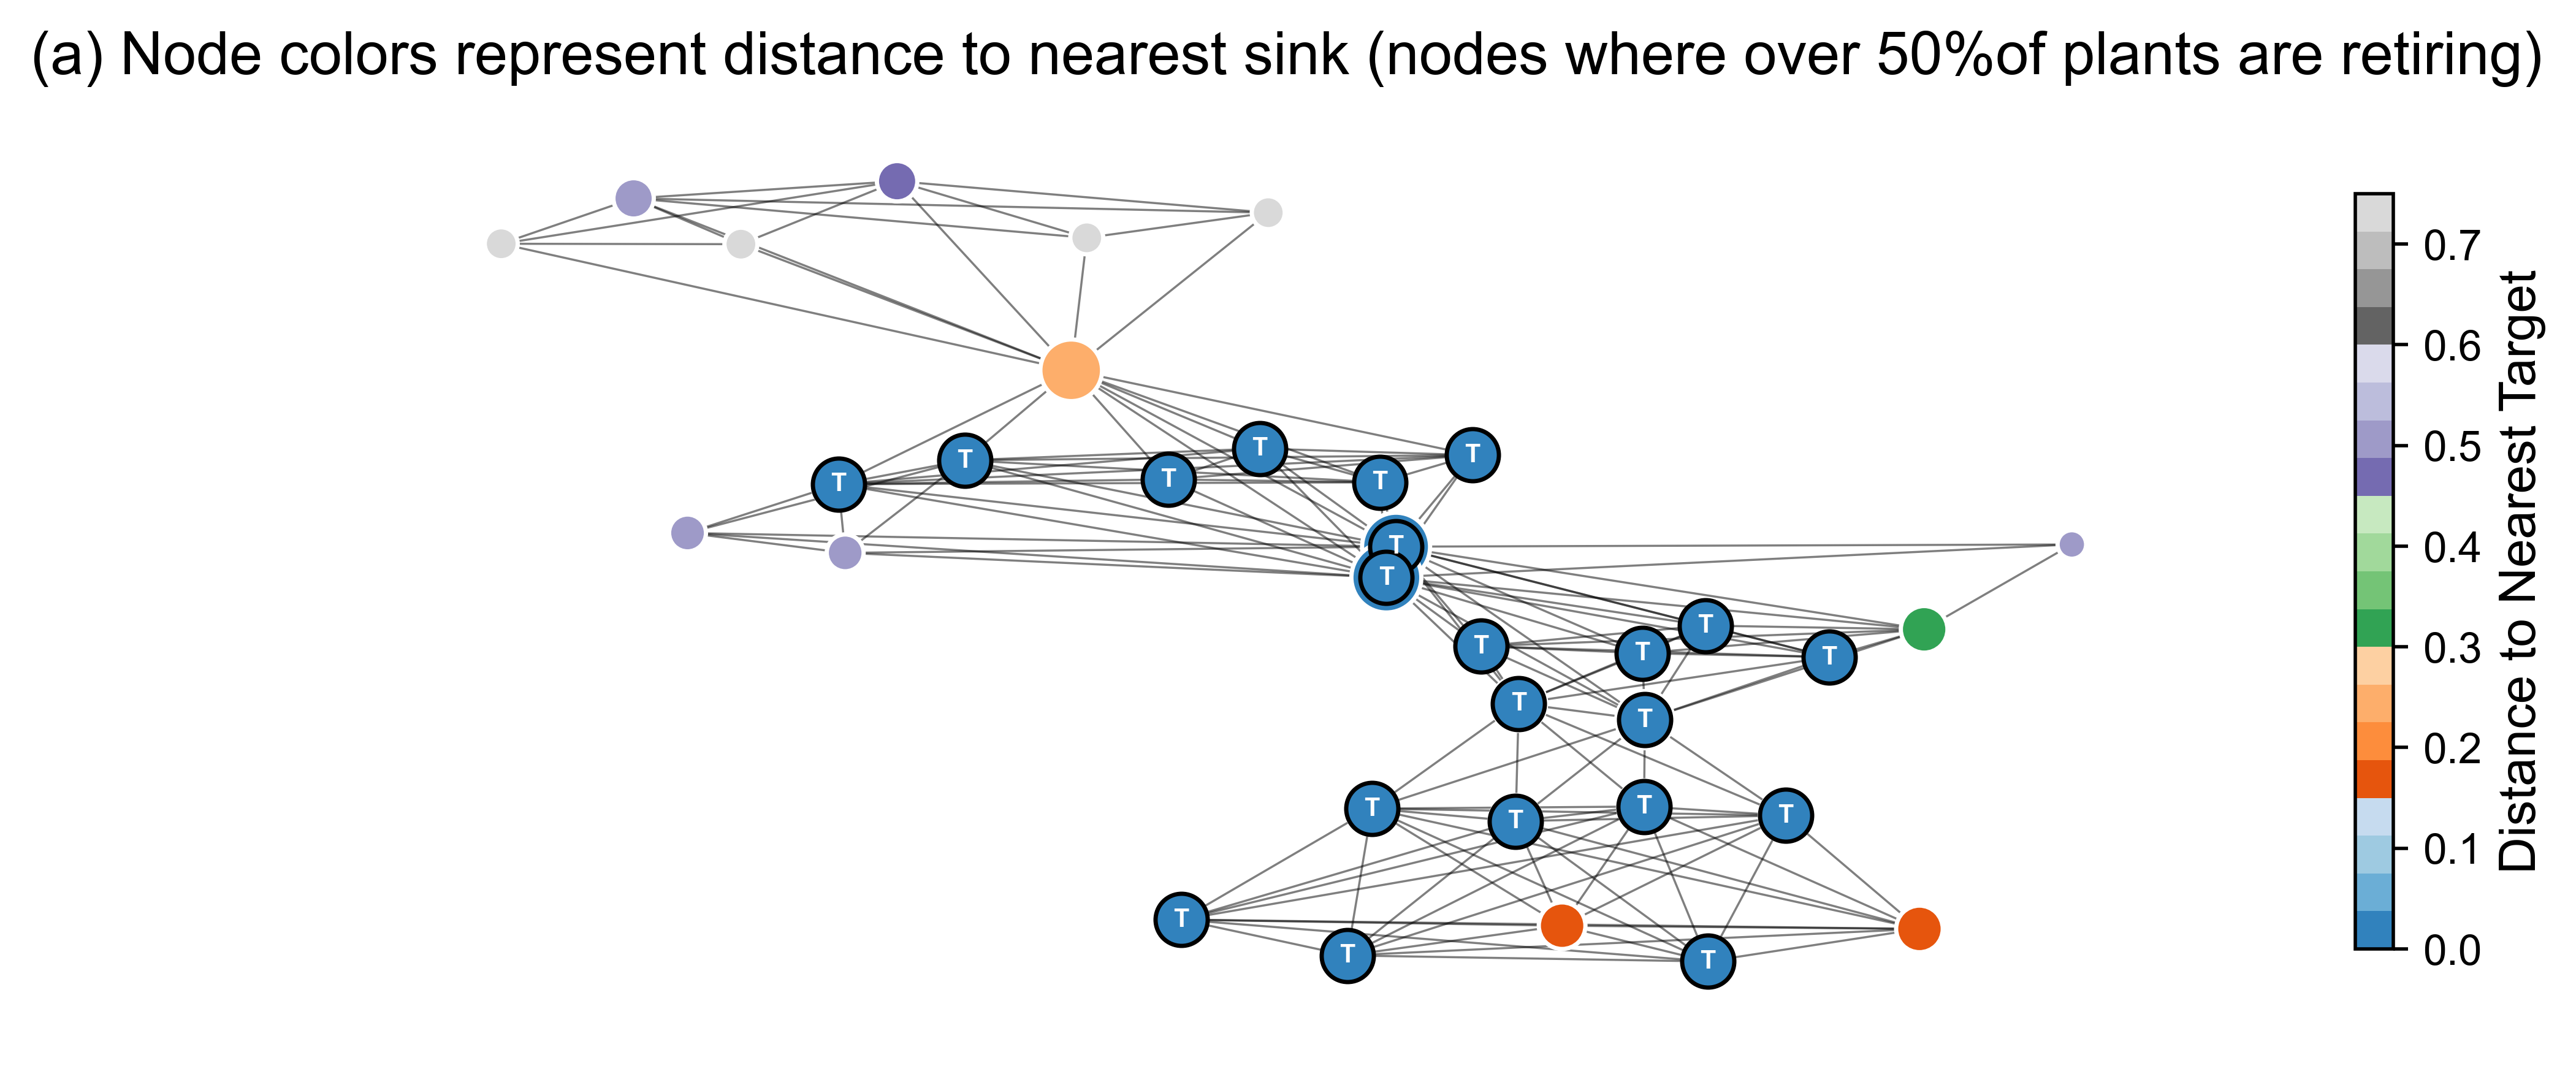

In [8]:
component = 3
threshold = 0.5 
col = "Percent Capacity Retiring"
retiring_nodes = plotkit.get_target_nodes(component=component,  col=col, threshold=threshold)
node_distances = plotkit.get_shortest_distances_to_targets(component=component, targets=retiring_nodes)
fig, ax = plotkit.drawPathDistance(component=component, 
                    targets=retiring_nodes, 
                    distances_dict=node_distances, 
                    title="(a) Node colors represent distance to nearest sink (nodes where over 50%of plants are retiring)",
                    seed=5, 
                    show_colorbar=True)

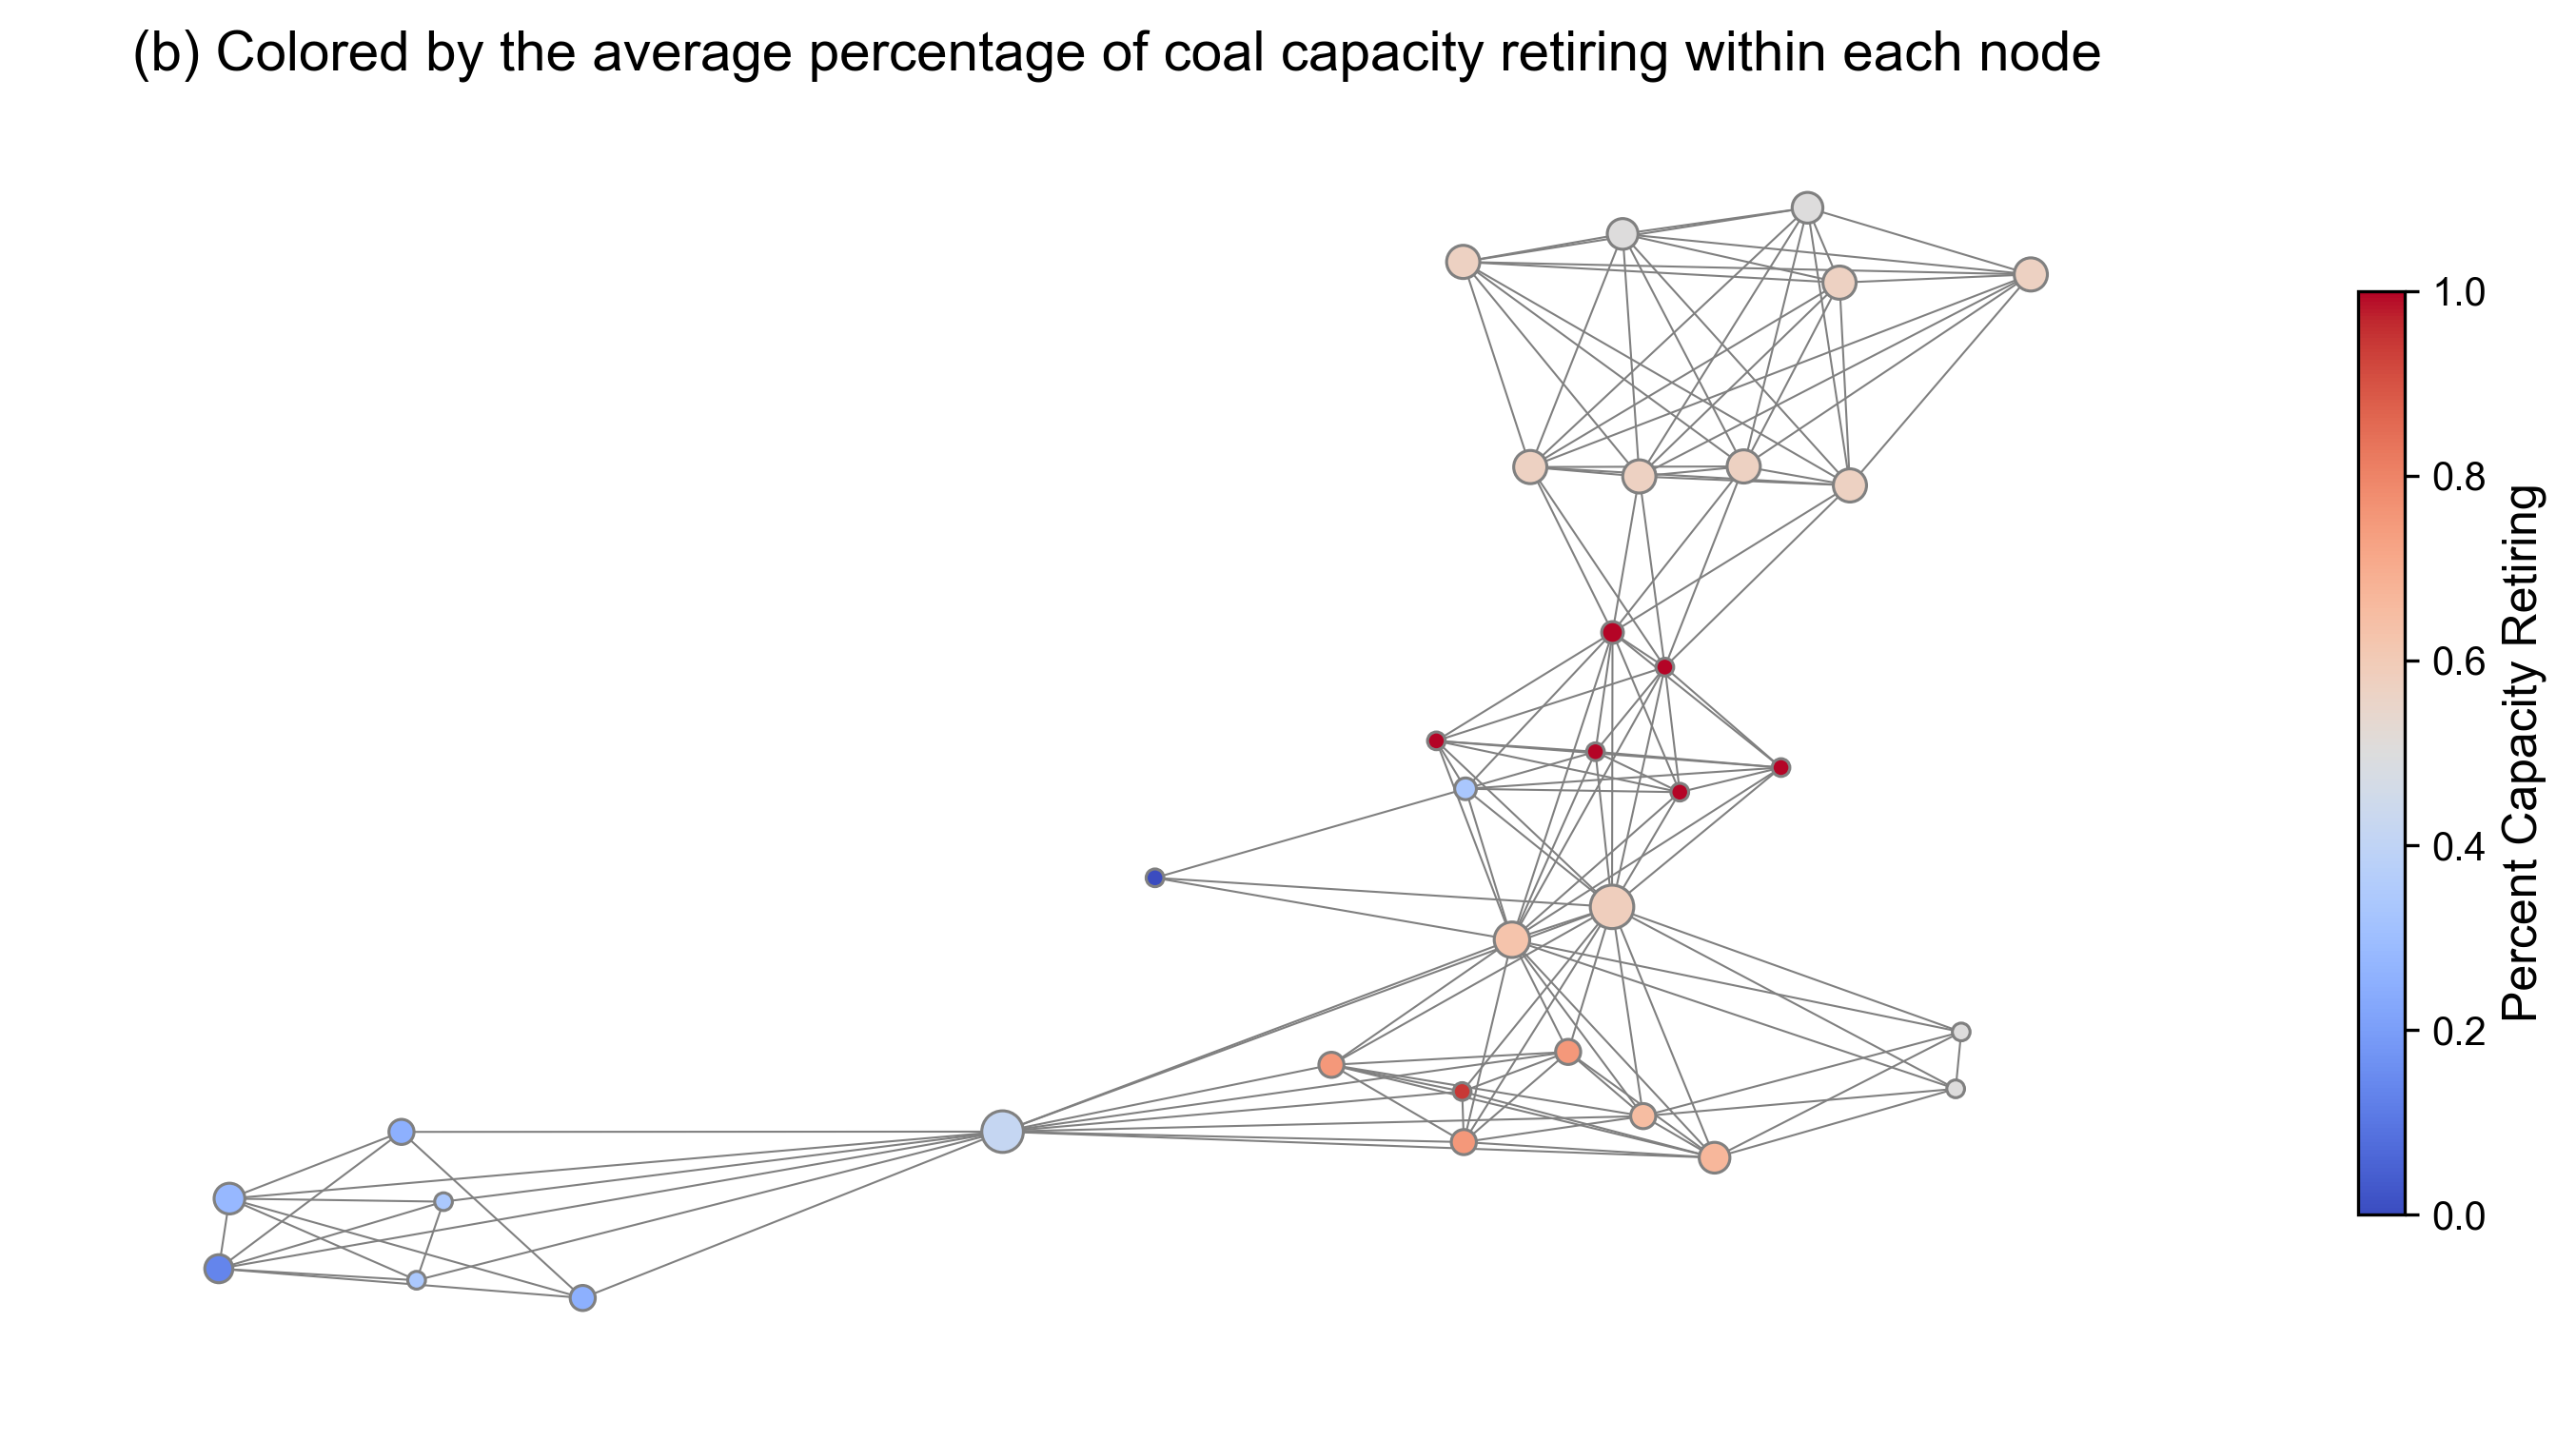

In [9]:
fig, ax = plotkit.drawComponent(component=3, show_colorbar=True, col="Percent Capacity Retiring", title="(b) Colored by the average percentage of coal capacity retiring within each node " ) 

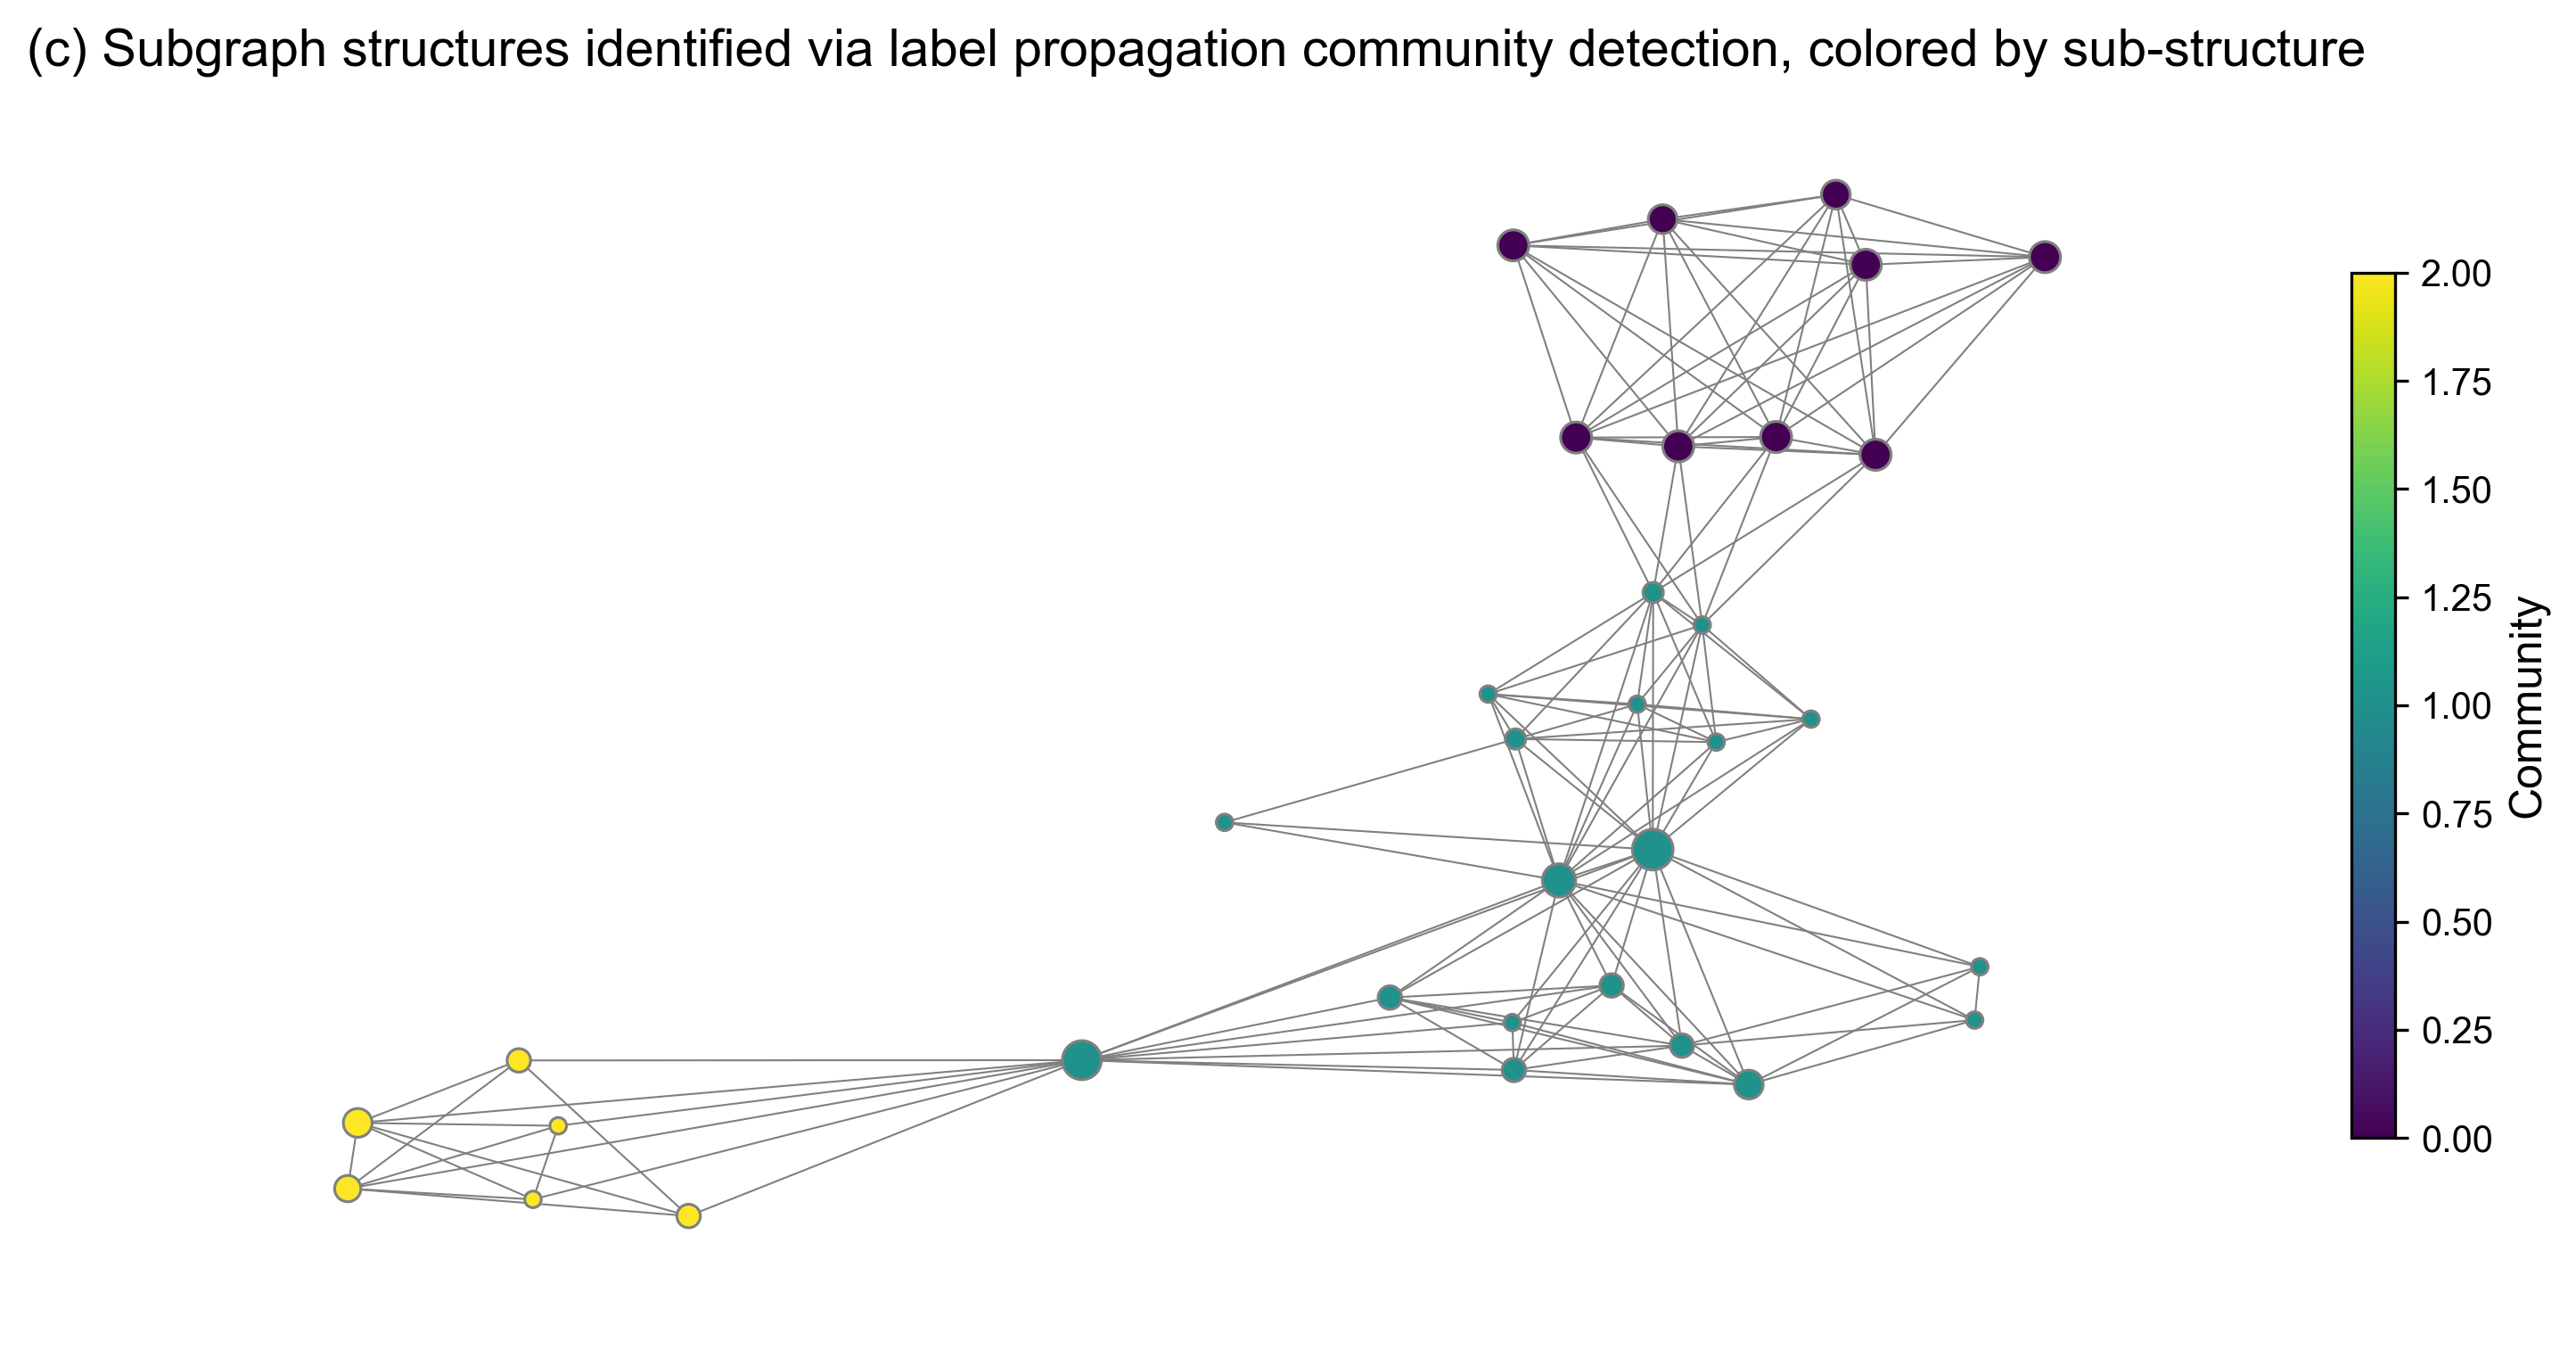

In [10]:
fig, ax = plotkit.drawComponent(component=3, color_method="community", show_colorbar=True, title="(c) Subgraph structures identified via label propagation community detection, colored by sub-structure")

## Figure 7: Coal Fleet Proximity to Retirement

In [11]:
fig, ax = plotkit.drawBar(title="Fleet Vulnerability Breakdown")

In [12]:
fig, ax = plotkit.drawSankey(title="Group Proximatey to Retirement") 


## Figure 8: Representational Variability in Coal Plant Modeling via UMAP and Mapper

In [13]:
def plot_umap_grid(df, n_neighbors_list=[3, 5, 10], min_dist_list=[0.05, 0.15, 0.5]):
    data = StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))
    records = []
    base_palette = px.colors.qualitative.Plotly
    param_grid = list(product(min_dist_list, n_neighbors_list))

    for min_dist, n_neighbors in tqdm(param_grid, desc="Generating UMAPs"):
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, n_jobs=1)
        embedding = reducer.fit_transform(data)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
        labels = clusterer.fit_predict(embedding)

        for x, y, label in zip(embedding[:, 0], embedding[:, 1], labels):
            color = 'rgba(150,150,150,0.3)' if label == -1 else base_palette[label % len(base_palette)]
            records.append({
                'UMAP1': x,
                'UMAP2': y,
                'cluster': str(label),
                'color': color,
                'n_neighbors': n_neighbors,
                'min_dist': min_dist,
            })

    plot_df = pd.DataFrame.from_records(records)

    # Prepare subplots
    rows = len(min_dist_list)
    cols = len(n_neighbors_list)
    fig = make_subplots(rows=rows, cols=cols, 
                        horizontal_spacing=0.02, vertical_spacing=0.02,
                        subplot_titles=[f"{n} / {m}" for m in min_dist_list for n in n_neighbors_list])

    for i, (min_dist, n_neighbors) in enumerate(param_grid):
        sub_df = plot_df[
            (plot_df['min_dist'] == min_dist) & 
            (plot_df['n_neighbors'] == n_neighbors)
        ]
        row = min_dist_list.index(min_dist) + 1
        col = n_neighbors_list.index(n_neighbors) + 1

        for cluster in sub_df['cluster'].unique():
            cluster_df = sub_df[sub_df['cluster'] == cluster]
            fig.add_trace(
                go.Scattergl(
                    x=cluster_df['UMAP1'], 
                    y=cluster_df['UMAP2'],
                    mode='markers',
                    marker=dict(color=cluster_df['color'].iloc[0], size=3),
                    showlegend=False,
                    hoverinfo='skip'
                ),
                row=row, col=col
            )

        # Clean up axes
        fig.update_xaxes(showticklabels=False, ticks="", row=row, col=col)
        fig.update_yaxes(showticklabels=False, ticks="", row=row, col=col)

    # Layout and annotations
    fig.update_layout(
        template='simple_white',
        plot_bgcolor='white',
        margin=dict(l=100, r=100, t=80, b=80),
    )

    # Remove subplot titles (replaced with simplified axis annotations)
    fig.update_layout(annotations=[
        a.update(text='') or a for a in fig['layout']['annotations']
    ], height=500)



    # Add row (min_dist) labels on the left
    for i, min_dist in enumerate(min_dist_list):
        fig.add_annotation(
            text=f"min-dist: {min_dist}",
            x=-0.05,  # just outside the plot grid
            y=1 - (i + 0.5) / rows,
            xref="paper", yref="paper",
            showarrow=False,
            font=dict(size=12),
            xanchor="right",
            yanchor="middle",
            align="right",
            textangle=90,
        )

    # Add column (n_neighbors) labels at the bottom
    for j, n_neighbors in enumerate(n_neighbors_list):
        fig.add_annotation(
            text=f"n-neighbors: {n_neighbors}",
            x=(j + 0.5) / cols,
            y=-0.08,
            xref="paper", yref="paper",
            showarrow=False,
            font=dict(size=12),
            xanchor="center",
            yanchor="top",
        )


    fig.show(config={"toImageButtonOptions": {"format": "svg"}})
    return plot_df

In [14]:

umaps = plot_umap_grid(clean_df)

Generating UMAPs:   0%|          | 0/9 [00:00<?, ?it/s]

/Users/stuartwayland/Projects/public/CoalAPI/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/stuartwayland/Projects/public/CoalAPI/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/stuartwayland/Projects/public/CoalAPI/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/stuartwayland/Projects/public/CoalAPI/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/stuartwayland/Projects/public/CoalAPI/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: Future